### R-CNN object detection architecture

### Rich feature hierarchies for accurate object detection and semantic segmentation (Girshick R. et al., 2014, UC Berkeley)

[Paper](https://arxiv.org/abs/1311.2524)

*Our approach combines two key insights: (1) one can apply high-capacity convolutional neural networks (CNNs) to bottom-up region proposals in order to localize and segment objects and (2) when labeled training data is scarce, supervised pre-training for an auxiliary task, followed by domain-specific fine-tuning, yields a significant performance boost.*

### Region-based convolutional networks for accurate object detection and segmentation (Girshick R. et al., 2015)

[Paper](https://ieeexplore.ieee.org/document/7112511)


### Selective Search for Object Recognition (Uijlings J. R. R. et al. , 2013)
[Paper](https://www.researchgate.net/profile/Jasper-Uijlings/publication/262270555_Selective_Search_for_Object_Recognition/links/542017f70cf2218008d43bd7/Selective-Search-for-Object-Recognition.pdf?origin=publication_detail)
! Technical Report was submited in  2012.

In [1]:
import os
import glob
import tqdm
import numpy as np
import netron
from typing import Tuple, Callable

import cv2

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names

from ignite.engine import  create_supervised_evaluator
from ignite.metrics import Fbeta, ConfusionMatrix

from sklearn.metrics import confusion_matrix, f1_score, mean_squared_error
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import RidgeCV, ElasticNetCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline

import matplotlib.pyplot as plt

assert torch.cuda.is_available() is True
%load_ext watermark

In [2]:
%watermark -p torch,ignite,numpy,cv2,sklearn

torch  : 1.10.2
ignite : 0.4.8
numpy  : 1.22.1
cv2    : 4.5.5
sklearn: 0.24.2



R-CNN - Region-based Convolutional Network

* Ideas from "Selective Search" paper:
1. Get rid of sliding windows. Create a list of proposed regions, hypotheses with possible location of an object.
2. Use __selective search__ as proposals extractor.
3. Extract features via __image descriptors__ from ground truth and proposed regions.
4. Train classifier with one-vs-all strategy (originally, SVM).
5. Evaluate with MABO (Mean Average Best Overlap, an average of max IoU for each ground truth averaged by the number of classes)

<img src="../assets/1_rcnn.png" width="950">
Scheme from (Uijlings J. R. R. et al. , 2013)


"__*This paper addresses the problem of generating possible object locations for use in object recognition. We introduce Selective Search which combines the strength of both an exhaustive search and segmentation.*__"

__Selective search__ is the algorithm which can be divided into segmentation and clustering tasks.
It starts by oversegmenting the image based on intensity of the pixels using a [graph-based segmentation method](http://cs.brown.edu/people/pfelzens/segment/) and can be briefly described as the iterative process of joining  segments based on various similarity metrics and color spaces.

####  Simple shapes & Selective search

In [3]:
import utils
import metrics
import training

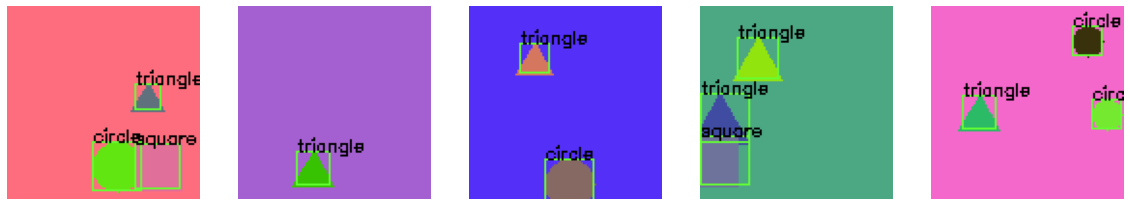

In [4]:
shapes2d = utils.RandomShapes(img_size=100, w=30, h=30, seed=123)

n_shapes = 5
gt_flag = True
gt_color = (100, 255, 50)
class_color = (0, 0, 0)

examples = [shapes2d.get_image() for _ in range(n_shapes)]
imgs = [x[0] for x in examples]
gtruth = [x[1] for x in examples]
fig, axs = plt.subplots(1, n_shapes, figsize=(20,20))

for i, img in enumerate(imgs):
    img_copy = img.copy()
    if gt_flag:
        for class_id, pts in gtruth[i]:
            cv2.rectangle(img_copy, pts, gt_color, 1)
            cv2.putText(img_copy, shapes2d.classes[class_id-1], pts[:2], 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.3, class_color)

            
    axs[i].imshow(img_copy)
    axs[i].axis('off')

plt.show()

In [5]:
def cv2_ssearch(image: np.ndarray, fast: bool = True) -> np.ndarray:
    """
    :param image: input image
    :param fast:  process mode flag
    :return: rectangular proposals with shape=(n, 4)
    """
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    if fast:
        ss.switchToSelectiveSearchFast()
    else:
        ss.switchToSelectiveSearchQuality()
    return ss.process()

(-0.5, 99.5, 99.5, -0.5)

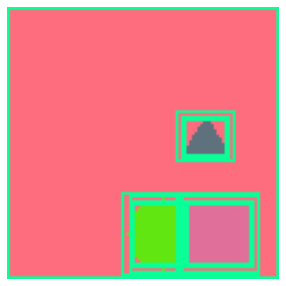

In [6]:
img1_copy = imgs[0].copy()
rects = cv2_ssearch(img1_copy)

n_draws = 20
for pts in rects[:n_draws]:
    cv2.rectangle(img1_copy, pts, (10, 255, 150), 1)
    
fig = plt.figure(figsize=(5,5))
plt.imshow(img1_copy)
plt.axis('off')

#### How R-CNN works:

<img src="../assets/2_rcnn.png" width="550">

1. Extract proposals via selective search.

*Note: R-CNN is agnostic to to the particular region proposal method.*

2. Dilate bboxes (surrounding image context), extract proposals as image crops, resize to 227х227 squares.


3. Fine-tuning AlexNet-based ILSVRC2012 pretrained feature extractor (1 11x11 Conv, 1 5x5 Conv, 3 3x3 Conv, 2 FC up to hidden state vector with 4096x1x1 output tensor):

* N classes + 1 background class. 

* How to treat proposals for CNN:

    $proposal=\left\{ 
      \begin{array}{ c l }
        positive, & \quad IoU_{(proposal, GT)} \ge 0.5 \\
        negative (background), & \quad IoU_{(proposal, GT)} < 0.5
      \end{array}
    \right.$
    
    
* Batch: 32 positive, 96 negative proposals.


Training with negative examples.


In [7]:
class RCNNFeatureModule(nn.Module):
    
    def __init__(self, n_classes: int, input_channels: int = 3):
        super(RCNNFeatureModule, self).__init__()
        
        self.input_channels = input_channels
        self.n_classes = n_classes
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        
        self.conv1 = nn.Conv2d(self.input_channels, 96, kernel_size=11, stride=4)
        nn.BatchNorm1d(32)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        
        self.conv2 = nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        
        self.conv3 = nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1)
        
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.linear1 = nn.Linear(256*6*6, 4096)
        
        self.linear2 = nn.Linear(4096, 4096)
        self.linear3 = nn.Linear(4096, self.n_classes)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        z = self.maxpool1(self.relu(self.conv1(x)))
        z = self.maxpool2(self.relu(self.conv2(z)))
        
        z = self.relu(self.conv3(z))
        z = self.relu(self.conv4(z))
        z = self.relu(self.conv5(z))
        z = self.maxpool3(z)
        
        z = z.view(-1, 256*6*6)
        z = self.relu(self.linear1(z))
        z = self.dropout(z)
        z = self.relu(self.linear2(z))
        z = self.dropout(z)
        z = self.relu(self.linear3(z))
        return z

In [8]:
rcnn_extractor = RCNNFeatureModule(n_classes=4).eval()
x = torch.Tensor(np.random.normal(size=(3, 227, 227)))
model_path = os.path.join('onnx_graphs', 'rcnn_extractor.onnx')
torch.onnx.export(rcnn_extractor, torch.unsqueeze(x, 0), model_path,
                  input_names=['input'], output_names=['output'], opset_version=10)

In [9]:
netron.start(model_path, 30000)

Serving 'rcnn_extractor.onnx' at http://localhost:30000


('localhost', 30000)

4. One-vs-all SVM classifier for latent feature space with shape 4096x1x1. 

Each crop is:

* negative: $IoU_{(proposal, GT)} < 0.3$,
* not used: $0.3 \le IoU_{(proposal, GT)} < 0.5 $,
* ground truth: $IoU_{(proposal, GT)} \ge 0.5$.


5. Increase localization accuracy with __bounding box regression__ problem with last pooling output:


Let:
* $\phi_{pool}(P)$ returns the tensor after the last pooling layer with a proposal $P$.
* $d_{i}=d_{i}(P) -$ functions for elements $i=\{x, y, w, h\}$ which describe any bbox center.
* $d_{i}(P) = w^T\phi_{pool}(P)$, where $w-$ the vector of learnable parameters in linear regressions.


$P = (P_x, P_y, P_w, P_h) - $ selective search bbox, $Px, Py - $ bbox center,\
$G = (G_x, G_y, G_w, G_h) - $ ground truth, then:

$$G_x = P_w d_x(P) + P_x, $$\
$$G_y = P_h d_y(P) + P_y, $$\
$$G_w = P_w exp(d_w(P)), $$\
$$G_h = P_h exp(d_h(P)).$$

Thus, the idea is to train linear functions to adjust selective search bbox coordinates.

Instead of FC output last pooling one preserves more structure information for bbox coordinates.

L2-Regularization (Ridge regressions).

Targets for regressions are scale-invariant offsets from bbox proposal center:

$$t_x = \frac{G_x - P_x}{P_w},$$\
$$t_y = \frac{G_y - P_y}{P_h},$$\
$$t_x = ln\frac{G_w}{P_w},$$\
$$t_x = ln\frac{G_h}{P_h}.$$

Training scheme:

<img src="../assets/4_rcnn.svg" width="530">


Dataset example for 2DShapes

In [9]:
class ShapesDataset(Dataset):

    def __init__(self, n_images: int, img_size: int, seed: int, dilation: int,
                 proposal_iou: float, proposal_count: int, shuffle_proposals: bool = True,
                 svm_background_iou: float = 0.3,
                 transform: Callable = None, 
                 name: str = 'default|',
                 verbose: bool = False):
        """
        Map-style ShapesDataset

        :param n_images:          number of images to generate
        :param img_size:          crop image size
        :param dilation:          bbox dilation, in pixels
        :param proposal_iou:      split to positive classes & negative one (Background)
        :param proposal_count:    number of proposals to use
        :param shuffle_proposals: random array shuffle
        :param svm_background_iou iou to define svm background class
        :param transform:         final crops transformations
        :param name:              dataset name
        :param verbose:           class versbosity
        """
        self.n_images = n_images
        self.transform = transform
        self.dilation = dilation
        self.proposal_iou = proposal_iou
        self.proposal_count = proposal_count
        self.shuffle_proposals = shuffle_proposals
        self.svm_background_iou = svm_background_iou
        self.img_size = img_size
        self.shapes2d = utils.RandomShapes(
            img_size=self.img_size, w=30, h=30, nms_threshold=0.1, seed=seed)
        self.name = name
        self.verbose = verbose
        self.fast_ssearch = True

        self._generate_dataset()
        self._generate_proposals()
        self._filter_proposals()

    @staticmethod
    def extract_gtruth(gtruth: list) -> Tuple[np.ndarray, int]:
        gt_bbox = [gt for _, gt in gtruth]
        gt_class_id = [idx for idx, _ in gtruth]
        return gt_bbox, gt_class_id

    @staticmethod
    def show_image(image: np.ndarray, title: str) -> None:
        fig = plt.figure()
        plt.imshow(image)
        plt.title(title)
        plt.axis('off')

    def _dilate_bbox(self, bbox: np.ndarray) -> np.ndarray:
        """
        Bboxes pixel-steps dilation. 
        It is not related to morhpoological transformation.

        Article:
        Prior to warping, we dilate the tight bounding box so that 
        at the warped size there are exactly p pixels of warped image 
        context around the original box (we use p = 16)
        """

        dilations = np.repeat(self.dilation, 4) * np.array([-1, -1, 1, 1])
        dilated_bbox = bbox + dilations

        for i in (0, 1):
            dilated_bbox[i] = max(0, dilated_bbox[i])
        for i in (2, 3):
            # We assume here that images are square
            dilated_bbox[i] = min(self.img_size, dilated_bbox[i])

        return dilated_bbox

    def _generate_dataset(self) -> None:
        print(f'{self.name} Generating dataset...')
        self.images_info = {}
        for i in range(self.n_images):
            bg_color, shape_specs, gtruths = self.shapes2d.generate_shapes()
            self.images_info.update({i: {'bg_color': bg_color,
                                         'shape_specs': shape_specs,
                                         'gtruths': gtruths
                                         }
                                     }
                                    )

    def _generate_proposals(self) -> None:
        print(f'{self.name} Generating proposals...')

        for img_id, img_info in tqdm.tqdm(self.images_info.items()):

            bg_color, shape_specs, gtruths = \
                img_info['bg_color'], img_info['shape_specs'], img_info['gtruths']
            img = self.shapes2d.generate_image_by_desc(bg_color, shape_specs)
            proposals = cv2_ssearch(img, self.fast_ssearch)

            if self.shuffle_proposals:
                np.random.shuffle(proposals)
            proposals = proposals[:self.proposal_count, :]

            self.images_info[img_id].update({'proposals': proposals})
            
    def _find_class_id(self, ious: list, gt_class_ids: list) -> Tuple[int, int]:
        
        best_iou = max(ious)
        
        if best_iou >= self.proposal_iou:
            class_id = gt_class_ids[np.argmax(ious)]
            svm_class_id = class_id
        else:
            class_id = 0
            svm_class_id = 0 if best_iou < self.svm_background_iou else -1
            
        return class_id, svm_class_id

    def _filter_proposals(self) -> None:
        print(f'{self.name} Filtering proposals with IoU={self.proposal_iou}...')

        self.image_proposals_map = []
        self.svm_proposals_classes = []
        self.regression_bbox_pairs = []
        
        for img_id in range(self.n_images):

            gtruths = self.images_info[img_id]['gtruths']
            proposals = self.images_info[img_id]['proposals']
            proposals_classes = []

            for p_id, p in enumerate(proposals):

                gt_bboxes, gt_class_ids = self.extract_gtruth(gtruths)
                ious = [metrics.get_iou(np.array(p), gt) for gt in gt_bboxes]

                if self.verbose:
                    print(f'{self.name} IoU(Proposal, GTs): {ious}')

                class_id, svm_class_id = self._find_class_id(ious, gt_class_ids)
                self.regression_bbox_pairs.append([p, gt_bboxes[np.argmax(ious)]])

                proposals_classes.append(class_id)
                self.image_proposals_map.append(img_id)
                self.svm_proposals_classes.append(svm_class_id)
                
            
            self.images_info[img_id].update({'proposals_classes': proposals_classes})

        self.proposals_classes = np.concatenate(
            [v['proposals_classes'] for v in self.images_info.values()]).astype(int)
        self.proposals = np.concatenate(
            [v['proposals'] for v in self.images_info.values()]).astype(int)
        self.image_proposals_map = np.array(self.image_proposals_map).astype(int)
        
        self.svm_proposals_classes = np.array(self.svm_proposals_classes).astype(int)
        self.regression_bbox_pairs = np.array(self.regression_bbox_pairs).astype(int)

        classes, counts = np.unique(self.proposals_classes, return_counts=True)
        print(
            f'Proposals class distribution:\n{ {k: v for k,v in zip(classes, counts)} }')

    def _get_proposal(self, idx) -> Tuple[np.ndarray, int]:

        class_id = self.proposals_classes[idx]
        proposal_bbox = self.proposals[idx]
        dilated_bbox = self._dilate_bbox(proposal_bbox)

        image_id = self.image_proposals_map[idx]
        image = self.shapes2d.generate_image_by_desc(self.images_info[image_id]['bg_color'],
                                                     self.images_info[image_id]['shape_specs'])
        crop = utils.crop_image(image, dilated_bbox)
        return crop, class_id

    def view_images(self, num: int, bbox_flag: bool = True, classs_flag: bool = True,
                    text_size: float = 0.3, txt_color: tuple = (0, 0, 0),
                    gt_color: tuple = (100, 255, 50), ) -> None:

        keys = list(self.images_info.keys())
        np.random.shuffle(keys)

        for k in keys[:num]:

            bg_color = self.images_info[k]['bg_color']
            shape_specs = self.images_info[k]['shape_specs']
            gtruths = self.images_info[k]['gtruths']

            image = self.shapes2d.generate_image_by_desc(bg_color, shape_specs)

            for class_id, bbox in gtruths:
                if bbox_flag:
                    cv2.rectangle(image, bbox, gt_color, 1)
                if classs_flag:
                    cv2.putText(image, self.shapes2d.classes[class_id-1], bbox[:2],
                                cv2.FONT_HERSHEY_SIMPLEX, text_size, txt_color)

            self.show_image(image, f'Image {k}')

    def view_proposals(self, num: int) -> None:

        crop_idx = np.random.randint(0, self.__len__(), num)
        for idx in crop_idx:
            crop, class_id = self._get_proposal(idx)
            self.show_image(crop, f'Class proposal: {class_id}')

    def __len__(self) -> int:
        return self.proposals_classes.shape[0]

    def __getitem__(self, idx) -> Tuple[np.ndarray, int]:

        crop, class_id = self._get_proposal(idx)

        if self.transform:
            crop = self.transform(crop)

        return crop, class_id

In [10]:
transforms = [
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((50, 50)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]

In [11]:
datasets = {}
for name, n_images, seed in zip(('train', 'val', 'test'),
                                (300, 50, 20),
                                (123, 321, 42)):
    datasets.update({name:
                     ShapesDataset(
                         n_images=n_images,
                         img_size=100,
                         seed=seed,
                         dilation=8,
                         proposal_iou=0.5,
                         proposal_count=2000,
                         transform=torchvision.transforms.Compose(transforms),
                         name=name)
                     }
                    )

train Generating dataset...
train Generating proposals...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:10<00:00, 27.70it/s]


train Filtering proposals with IoU=0.5...
Proposals class distribution:
{0: 593, 1: 512, 2: 1086, 3: 413}
val Generating dataset...
val Generating proposals...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 28.56it/s]


val Filtering proposals with IoU=0.5...
Proposals class distribution:
{0: 69, 1: 83, 2: 133, 3: 77}
test Generating dataset...
test Generating proposals...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 28.15it/s]

test Filtering proposals with IoU=0.5...
Proposals class distribution:
{0: 31, 1: 33, 2: 78, 3: 29}


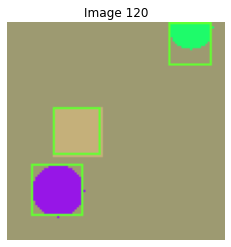

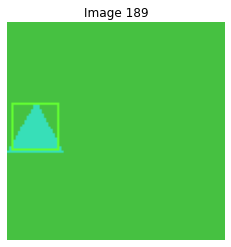

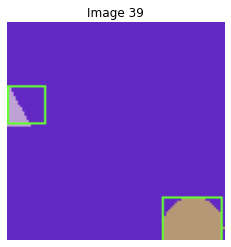

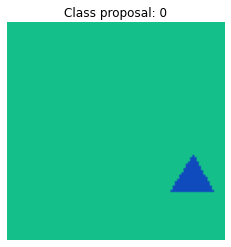

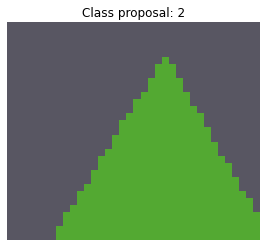

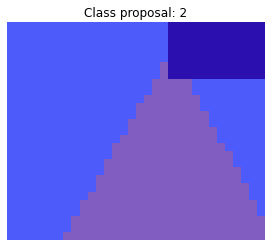

In [12]:
datasets['train'].view_images(3, classs_flag=False)
datasets['train'].view_proposals(3)

Weighted batch sampler is aimed to increase negative proposals in each batch according to `neg_pos_ratio`:

In [13]:
def set_class_weights(n_classes: int, neg_pos_ratio: int) -> list:
    """
    :param n_classes,     number of classes including the background class
    :param neg_pos_ratio, negative samples / positive samples
    :return: list of weights
    """
    weights = [1] * n_classes
    weights[0] = neg_pos_ratio * (n_classes-1)
    return weights

def set_weights_to_samples(weights: list, labels: list or np.ndarray)-> torch.DoubleTensor:
    """
    :param weights, weights, where index is the class label
    :param labels,  class labels in the dataset
    :return: tensor of weights per observation/label
    """
    samples_weights = [weights[c] for c in labels]
    samples_weights = torch.DoubleTensor(samples_weights)
    return samples_weights

In [14]:
# Basic parameters for CNN feature extractor

n_classes = len(datasets['train'].shapes2d.classes) + 1
neg_pos_ratio = 3
batch_size = 12

epochs = 10
l_rate = 0.001
device = 'cuda'

train_flag = False

In [15]:
# Set class weights for batch sampler
class_weights = set_class_weights(n_classes, neg_pos_ratio)
samples_weights = set_weights_to_samples(class_weights, datasets['train'].proposals_classes)
sampler = WeightedRandomSampler(samples_weights, len(samples_weights))

# Init dataloaders
train_loader = DataLoader(datasets['train'], batch_size=batch_size, sampler=sampler)
val_loader = DataLoader(datasets['val'], batch_size=batch_size)
test_loader = DataLoader(datasets['test'], batch_size=batch_size)

# Init CNN feature extractor 
rcnn_mbnet = torchvision.models.mobilenet_v2(pretrained=True, progress=False)
rcnn_mbnet.classifier[1] = nn.Linear(in_features=1280, out_features=n_classes)
rcnn_mbnet = rcnn_mbnet.to(device)

In [16]:
if train_flag:
    optimizer = torch.optim.Adam(rcnn_mbnet.parameters(), lr=l_rate)
    criterion = nn.CrossEntropyLoss()
    training.train_model(train_loader=train_loader,
                        val_loader=val_loader,
                        dataset_name='shapes2d',
                        model=rcnn_mbnet,
                        model_name='rcnn_mbnet',
                        optimizer=optimizer,
                        criterion=criterion,
                        metrics = {'f1': Fbeta(beta=1)},
                        checkpoint_dir=os.path.join(
                            '.', 'saved_models', 'rcnn_mbnet'),
                        checkpoint_metric='f1',
                        epochs=epochs,
                        device=device)
else:
    path = glob.glob(os.path.join('.', 'saved_models',
                     'rcnn_mbnet', 'rcnn_mbnet_shapes2d*.pt'))[0]
    print(f'Loading weights: {path}')
    rcnn_mbnet.load_state_dict(torch.load(path, map_location=device))
    rcnn_mbnet = rcnn_mbnet.eval()

Loading weights: ./saved_models/rcnn_mbnet/rcnn_mbnet_shapes2d_5_0.9137.pt


Let's test the model:

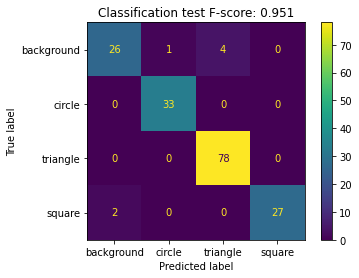

In [17]:
test_engine = create_supervised_evaluator(
    rcnn_mbnet,
    metrics={'f1': Fbeta(beta=1),
             'cm': ConfusionMatrix(num_classes=n_classes)},
    device=device
)

state = test_engine.run(test_loader)
utils.plot_confusion_matrix(state.metrics['cm'].numpy(), 
                           ['background', *datasets['train'].shapes2d.classes],
                           'Classification test F-score: %.3f' % state.metrics['f1'])

SVMs & regressions:

In [18]:
# Prepare SVMs data
X_cls_train, y_cls_train = utils.get_svm_dataset(model=rcnn_mbnet, 
                                                 dataset=datasets['train'],
                                                 device=device)
X_cls_test, y_cls_test = utils.get_svm_dataset(model=rcnn_mbnet, 
                                               dataset=datasets['test'], 
                                               device=device)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 109.93it/s]


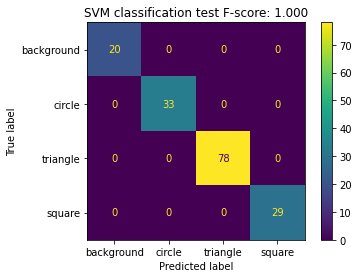

In [19]:
# Train & test Onve-vs-all default SVM with CNN features
svm_classfifier = make_pipeline(StandardScaler(), OneVsRestClassifier(SVC(probability=True)))
svm_classfifier.fit(X_cls_train, y_cls_train)

y_cls_pred = svm_classfifier.predict(X_cls_test)
cmatrix = confusion_matrix(y_cls_test, y_cls_pred)
svm_f1_test = f1_score(y_cls_test, y_cls_pred, average='macro')

utils.plot_confusion_matrix(cmatrix,
                            ['background', *datasets['train'].shapes2d.classes],
                            'SVM classification test F-score: %.3f' % svm_f1_test)

Why is it so?

The most probable answer is the difference between max log-likelihood vs margin maximization approaches.

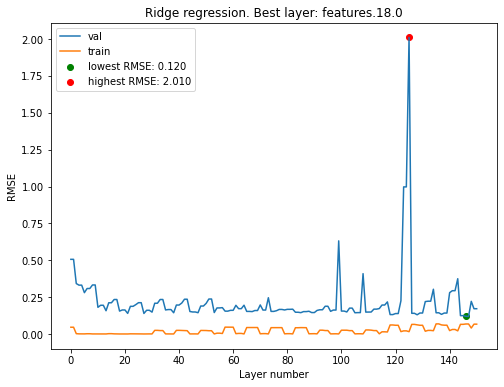

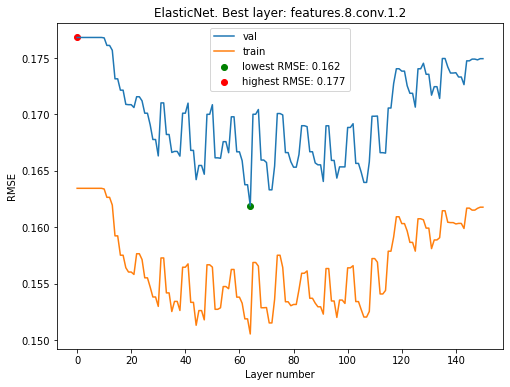

In [20]:
# Which layer should be used for bbox regression ?

# We will use train data with LOO-CV for regressions.
# And val data to define which CNN layer is better for feature extraction.

collect_scores = False
train_scores, val_scores = [], []
feature_layers = [layer for layer in get_graph_node_names(rcnn_mbnet)[0]
                  if layer not in ('x', 'classifier.0', 'classifier.1')]
scores_path = os.path.join('.', 'saved_models', 'rcnn_mbnet')

if collect_scores:

    for layer in tqdm.notebook.tqdm(feature_layers):

        X_reg_train, y_reg_train = utils.get_regression_dataset(model=rcnn_mbnet,
                                                                dataset=datasets['train'],
                                                                feature_layer=layer,
                                                                device=device)
        X_reg_test, y_reg_test = utils.get_regression_dataset(model=rcnn_mbnet,
                                                              dataset=datasets['val'],
                                                              feature_layer=layer,
                                                              device=device)
        ridge_reg = make_pipeline(StandardScaler(),
                                  MultiOutputRegressor(RidgeCV(
                                      alphas=(0.1, 0.3, 0.5),
                                  )
        )
        )
        ridge_reg.fit(X_reg_train, y_reg_train)
        cv_score = ridge_reg.score(X_reg_train, y_reg_train)

        y_test_pred = ridge_reg.predict(X_reg_test)
        val_rmse = np.sqrt(mean_squared_error(y_reg_test, y_test_pred))

        y_train_pred = ridge_reg.predict(X_reg_train)
        train_rmse = np.sqrt(mean_squared_error(y_reg_train, y_train_pred))

        train_scores.append(train_rmse)
        val_scores.append(val_rmse)
        print(f'Layer: {layer} RMSE: %.3f %.3f' % (train_rmse, val_rmse))

    with open(os.path.join(scores_path, 'train_rmse_reg.npy'), 'wb') as f:
        np.save(f, np.array(train_scores))
    with open(os.path.join(scores_path, 'val_rmse_reg.npy'), 'wb') as f:
        np.save(f, np.array(val_scores))

else:
    utils.plot_scores(feature_layers,
                      os.path.join(scores_path, 'train_rmse_reg.npy'),
                      os.path.join(scores_path, 'val_rmse_reg.npy'),
                      'Ridge regression'
                      )
    utils.plot_scores(feature_layers,
                      os.path.join(scores_path, 'train_rmse_elnet.npy'),
                      os.path.join(scores_path, 'val_rmse_elnet.npy'),
                      'ElasticNet'
                      )

In [21]:
mbnet_layer = 'features.18.0'
X_reg_train, y_reg_train = utils.get_regression_dataset(model=rcnn_mbnet,
                                                        dataset=datasets['train'],
                                                        feature_layer=mbnet_layer,
                                                        device=device)
X_reg_val, y_reg_val = utils.get_regression_dataset(model=rcnn_mbnet,
                                                    dataset=datasets['val'],
                                                    feature_layer=mbnet_layer,
                                                    device=device)
X_reg_test, y_reg_test = utils.get_regression_dataset(model=rcnn_mbnet,
                                                    dataset=datasets['test'],
                                                    feature_layer=mbnet_layer,
                                                    device=device)

X_reg_train = np.concatenate([X_reg_train, X_reg_val])
y_reg_train = np.concatenate([y_reg_train, y_reg_val])

In [22]:
ridge_reg = make_pipeline(
    StandardScaler(),
    MultiOutputRegressor(RidgeCV(alphas=np.arange(0.05, 1.5, 0.25)))).fit(X_reg_train, y_reg_train)

trainval_rmse = np.sqrt(mean_squared_error(y_reg_train, ridge_reg.predict(X_reg_train)))
test_rmse = np.sqrt(mean_squared_error(y_reg_test, ridge_reg.predict(X_reg_test)))

print(f'alpha coefs: {[ridge_reg.steps[1][1].estimators_[x].alpha_ for x in range(4)]}')

# Total RMSE
print(f'Trainval RMSE: {trainval_rmse} Test RMSE: {test_rmse}')

# RMSE per target
dict([(t_name + '_rmse', np.sqrt(mean_squared_error(y_reg_test[:, t_idx], 
                            ridge_reg.predict(X_reg_test)[:, t_idx])))
      for t_name, t_idx in zip(('tx', 'ty', 'tw', 'th'), range(4))])

alpha coefs: [0.3, 1.05, 1.3, 1.3]
Trainval RMSE: 0.07499586656062049 Test RMSE: 0.12337486654796076


{'tx_rmse': 0.10839876596836992,
 'ty_rmse': 0.13461605370216126,
 'tw_rmse': 0.12205892797563721,
 'th_rmse': 0.12694595112305918}

Inference scheme:

<img src="../assets/3_rcnn.svg" width="430">

In [23]:
class RCNN:

    def __init__(self, feature_extractor: nn.Module, classifier: Pipeline, bbox_regressor: Pipeline,
                 transform: Callable, device: str, fast_ssearch: bool = True,
                 proposals_count: int = 2000, dilation: int = 8, img_size: int = 100):

        self.feature_extractor = feature_extractor
        self.classifier = classifier
        self.bbox_regressor = bbox_regressor
        self.transform = transform
        self.fast_ssearch = fast_ssearch
        self.proposals_count = proposals_count
        self.dilation = dilation
        self.img_size = img_size
        self.device = device
        self.background_class_idx = 0
        self.cls_threshold = 0.7

        self._prepare_feature_extractor()

    def _prepare_feature_extractor(self) -> None:

        self.feature_extractor = \
            create_feature_extractor(self.feature_extractor,
                                     {'flatten': 'cls_features',
                                      'features.18.0': 'reg_features'})
        self.feature_extractor = self.feature_extractor.eval()

    def _get_proposals(self, image: np.ndarray) -> np.ndarray:
        proposals = cv2_ssearch(image, self.fast_ssearch)
        np.random.shuffle(proposals)
        proposals = proposals[:self.proposals_count, :]
        return proposals

    def _dilate_bbox(self, bbox: np.ndarray) -> np.ndarray:
        dilations = np.repeat(self.dilation, 4) * np.array([-1, -1, 1, 1])
        dilated_bbox = bbox + dilations
        for i in (0, 1):
            dilated_bbox[i] = max(0, dilated_bbox[i])
        for i in (2, 3):
            # We assume here that images are square
            dilated_bbox[i] = min(self.img_size, dilated_bbox[i])
        return dilated_bbox

    def _get_features(self, batch: torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            features = self.feature_extractor.forward(batch.to(self.device))
        cls_features = features['cls_features'].cpu().numpy()
        reg_features = features['reg_features'].cpu().numpy()
        cls_features = cls_features.reshape(cls_features.shape[0], -1)
        reg_features = reg_features.reshape(reg_features.shape[0], -1)
        return cls_features, reg_features

    def _adjust_bbox(self, proposal_bbox: np.ndarray, ts: np.ndarray) -> np.ndarray:
        """
         P = (Px, Py, Pw, Ph)
         G = (Gx, Gy, Gw, Gh)
        """
        p_x, p_y, p_w, p_h = np.hsplit(proposal_bbox, 4)
        t_x, t_y, t_w, t_h = np.hsplit(ts, 4)

        g_x = p_w*t_x + p_x
        g_y = p_h*t_y + p_y
        g_w = p_w*np.exp(t_w)
        g_h = p_h*np.exp(t_h)

        centered_bbox = np.hstack([g_x, g_y, g_w, g_h])
        return centered_bbox.astype(int)

    def _prepare_preds(self, cls_proba: np.ndarray, reg_pred: np.ndarray,
                       proposal_bboxes: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:

        cls_pred = np.argmax(cls_proba, axis=1)
        class_mask = (cls_pred != self.background_class_idx) & (
            cls_proba.max(axis=1) > self.cls_threshold)

        cls_pred = cls_pred[class_mask]
        reg_pred = reg_pred[class_mask]

        proposal_bboxes = proposal_bboxes[class_mask]
        predicted_bboxes = self._adjust_bbox(proposal_bboxes, reg_pred)

        return cls_pred, predicted_bboxes

    def detect(self, image: np.ndarray):
        # Selective search
        proposal_bboxes = self._get_proposals(image)
        # Bboxes dilation
        proposal_bboxes = np.array([self._dilate_bbox(bbox)
                                   for bbox in proposal_bboxes])
        # Cropping
        proposal_crops = [utils.crop_image(
            image, bbox) for bbox in proposal_bboxes]
        # Batching proposals
        proposal_batch = torch.cat(
            [self.transform(crop).unsqueeze(0) for crop in proposal_crops])
        # Extract features
        cls_features, reg_features = self._get_features(proposal_batch)
        # Make predictions
        cls_proba = self.classifier.predict_proba(cls_features)
        reg_pred = self.bbox_regressor.predict(reg_features)
        cls_pred, bbox_pred = self._prepare_preds(
            cls_proba, reg_pred, proposal_bboxes)

        return cls_pred, bbox_pred

In [24]:
rcnn = RCNN(feature_extractor=rcnn_mbnet,
            classifier=svm_classfifier,
            bbox_regressor=ridge_reg,
            transform=torchvision.transforms.Compose(transforms),
            device=device,
           )

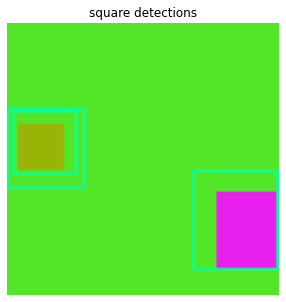

In [25]:
shapes2d = utils.RandomShapes(img_size=100, w=30, h=30, seed=23)

test_image = shapes2d.get_image()[0]
cls_pred, bbox_pred = rcnn.detect(test_image)

for class_idx in np.unique(cls_pred):
    img_copy = test_image.copy()
    for pts in bbox_pred[cls_pred==class_idx]:
        cv2.rectangle(img_copy, pts, (10, 255, 150), 1)
    fig = plt.figure(figsize=(5,5))
    plt.imshow(img_copy)
    plt.title(f'{shapes2d.classes[class_idx-1]} detections')
    plt.axis('off')


### Fast R-CNN (Girshick R., 2015, Microsoft Research)

[Paper](https://arxiv.org/abs/1504.08083)

* R-CNN model is a good step forward object detection but:
    * Class and bbox regression modules need to be prepared separately.
    * One-vs-all strategy for classiffier, 4 separate bbox regressions.
    * Time consuming operations beetween GPU mem & CPU ram.
    * ~2000 proposals for each image, ~2000 feature vectors.
    * The scheme takes too much time to make predictions.
    
Fast R-CNN ideas:

* Feed full image to the network
* Replace MaxPooling with __RoI Pooling__ layer:

<img src="../assets/1_fastrcnn.svg" width="650">

<img src="https://erdem.pl/4482c23c18077e16a560fb6add556cc7/ROI-pooling.gif" width="450">


*Note: In Fast R-CNN RoI Pool W=H=7*.

*Note: In RoI Pool we loose possible useful features if w/W & h/H are not completely divisible.*

* Classification and regression branches are inlcuded into CNN

* Multi-task loss:

    * discrete probability distribution per RoI: $p = (p_0, . . . , p_K ), K+1 -$ number of classes;

    * bbox offests for each possible class: $t^k = (t^k_x, t^k_y, t^k_w, t^k_h)$;
    
    * $u-$ ground truth class label, $v-$ ground truth bbox offsets;



$$L(p, u, t^u, v) = L_{cls}(p, u) + \lambda[u \ge 1]L_{loc}(t^u, v),$$where:

$L_{cls}(p, u) = -log(p_u)$, log loss for true class $u$;

$L_{loc}(t^u, v) = smooth_{L1}(t^u - v)$;

$smooth_{L1}(x) = [|x|< 1](0.5x^2) + (1-[|x|< 1]) (|x| - 0.5)$, Huber loss;

Note: In origin experiments $\lambda$ = 1.

* Batching: R proposals from N images, R/N from each image, 25% positive examples (IoU >= 0.5), 75% are negative ones.
Proposals with IoU < 0.1 are excluded.

In [26]:
print(torchvision.ops.roi_pool.__doc__)


    Performs Region of Interest (RoI) Pool operator described in Fast R-CNN

    Args:
        input (Tensor[N, C, H, W]): The input tensor, i.e. a batch with ``N`` elements. Each element
            contains ``C`` feature maps of dimensions ``H x W``.
        boxes (Tensor[K, 5] or List[Tensor[L, 4]]): the box coordinates in (x1, y1, x2, y2)
            format where the regions will be taken from.
            The coordinate must satisfy ``0 <= x1 < x2`` and ``0 <= y1 < y2``.
            If a single Tensor is passed, then the first column should
            contain the index of the corresponding element in the batch, i.e. a number in ``[0, N - 1]``.
            If a list of Tensors is passed, then each Tensor will correspond to the boxes for an element i
            in the batch.
        output_size (int or Tuple[int, int]): the size of the output after the cropping
            is performed, as (height, width)
        spatial_scale (float): a scaling factor that maps the input coordin

Training scheme:

<img src="../assets/2_fastrcnn.svg" width="650">

Inference scheme:

<img src="../assets/3_fastrcnn.svg" width="450">

### Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks (Ren S. et al., 2015)

[Paper](https://arxiv.org/abs/1506.01497)

* Original experiments: VGG-16, ZFNet(AlexNet-based)

* Region Proposal Network (RPN) instead of Selective search:

<img src="../assets/1_faster_rcnn.svg" width="950">


* Anchors mechanism:
    
  * It is possible because of convolution correspondence property of CNN’s.
  
  * Various scales and aspect ratios (3 scales, 3 ratios by default, k=9).
    
  * If the final feature map from feature extraction layer has width `W` and height `H` , then the total number of anchors generated will be `W*H*k`. (__VGG-16: 512x60x40 feature maps, 60x40x9=21600 proposals__).



* Faster R-CNN = RPN + Fast R-CNN, single, unified object detection neural network.

* There are several ways of training RPN+Faster RCNN.

Training scheme:

<img src="../assets/2_faster_rcnn.svg" width="750">

* RPN loss:
    
    $p_i-$ is the probability the the anchor $i$ has an object;
    
    $t_i-$ is the anchor offsets;
    
    $L_{cls}-$ logloss over 2 classes;
    
    $L_{reg}-$ Huber loss, smooth L-1;
    
    $$L_{RPN}(\{p_i\},\{t_i\})=\frac{1}{N_{cls}}\sum_i L_{cls}(p_i, p^*_i) + \lambda \frac{1}{N_{reg}} \sum_i p^*_i L_{reg}(t_i, t^*_i)$$
     
     $proposal=\left\{ 
  \begin{array}{ c l }
    positive, & \quad IoU_{(proposal, GT)} \ge 0.7 \\
    negative (background), & \quad IoU_{(proposal, GT)} < 0.3
  \end{array}
\right.$

Inference scheme:

<img src="../assets/3_faster_rcnn.svg" width="450">

In [27]:
[x for x in dir(torchvision.models.detection) if 'faster' in x]

['faster_rcnn',
 'fasterrcnn_mobilenet_v3_large_320_fpn',
 'fasterrcnn_mobilenet_v3_large_fpn',
 'fasterrcnn_resnet50_fpn']

* Pros:
    * Accurate detections
    * Anchors flexibility

* Cons:
    * Anchors-dependent
    * RoIs generation requires additional computations
    * Multistep training scheme
    * RoIs embeddings generally don't have context information about the whole input. Thus, false positives on background may occur.

#### References

* https://docs.opencv.org/4.x/d5/df0/group__ximgproc__segmentation.html
* http://cs.brown.edu/people/pfelzens/segment/
* https://learnopencv.com/selective-search-for-object-detection-cpp-python/
* http://cs.brown.edu/people/pfelzens/papers/lsvm-pami.pdf
* https://tensorboardx.readthedocs.io/en/latest/tutorial.html
* https://pytorch.org/docs/stable/generated/torch.nn.SmoothL1Loss.html
* https://en.wikipedia.org/wiki/Huber_loss
* https://erdem.pl/2020/02/understanding-region-of-interest-ro-i-pooling
* https://lilianweng.github.io/posts/2017-12-31-object-recognition-part-3/#fast-r-cnn
* https://kaushikpatnaik.github.io/annotated/papers/2020/07/04/ROI-Pool-and-Align-Pytorch-Implementation.html
* https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html